In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tpot import TPOTClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#valores estaticos
TEST_SIZE=0.20
RANDOM_STATE=42

In [3]:
df = pd.read_csv("../../data/processed/train/m1.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875419 entries, 1690 to 21260067
Data columns (total 56 columns):
6m                                875419 non-null int64
5m                                875419 non-null int64
4m                                875419 non-null int64
3m                                875419 non-null int64
2m                                875419 non-null int64
1m                                875419 non-null int64
edad_r                            875419 non-null int64
GENDER_F                          875419 non-null int64
GENDER_M                          875419 non-null int64
MARITAL_STATUS_Casado             875419 non-null int64
MARITAL_STATUS_Conviv             875419 non-null int64
MARITAL_STATUS_Divorciado         875419 non-null int64
MARITAL_STATUS_No Corresp         875419 non-null int64
MARITAL_STATUS_Separado           875419 non-null int64
MARITAL_STATUS_Soltero            875419 non-null int64
MARITAL_STATUS_Union Civ          875419 non

In [4]:
#distrib de churn
np.sum(df["Churn"]) / len(df)

0.030603630947009373

# Muestra random

In [5]:
msk = np.random.rand(len(df)) < 0.6

In [6]:
RANDOM_STATE=42
size = 0.6
"""
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=size, random_state=RANDOM_STATE)
for train_index, val_index in sss.split(X,y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

"""

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\n\nsss = StratifiedShuffleSplit(n_splits=1, test_size=size, random_state=RANDOM_STATE)\nfor train_index, val_index in sss.split(X,y):\n    X_train, X_val = X[train_index], X[val_index]\n    y_train, y_val = y[train_index], y[val_index]\n\n'

In [7]:
df = df[msk]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525616 entries, 1690 to 21179943
Data columns (total 56 columns):
6m                                525616 non-null int64
5m                                525616 non-null int64
4m                                525616 non-null int64
3m                                525616 non-null int64
2m                                525616 non-null int64
1m                                525616 non-null int64
edad_r                            525616 non-null int64
GENDER_F                          525616 non-null int64
GENDER_M                          525616 non-null int64
MARITAL_STATUS_Casado             525616 non-null int64
MARITAL_STATUS_Conviv             525616 non-null int64
MARITAL_STATUS_Divorciado         525616 non-null int64
MARITAL_STATUS_No Corresp         525616 non-null int64
MARITAL_STATUS_Separado           525616 non-null int64
MARITAL_STATUS_Soltero            525616 non-null int64
MARITAL_STATUS_Union Civ          525616 non

In [19]:
#distrib de churn
np.sum(df["Churn"] == 1) / np.sum(df["Churn"] == 0)

0.031311192996087575

In [22]:
df["Churn"].value_counts()

0    509658
1     15958
Name: Churn, dtype: int64

In [23]:
15958 / 509658

0.031311192996087575

# split data set

In [9]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [11]:
print("train: {} - test: {}".format(len(X_train), len(X_test)))

train: 420492 - test: 105124


In [12]:
#distrib de churn
np.sum(y_train) / len(y_train)

0.030352539406219382

In [13]:
X_train.head()

,6m,5m,4m,3m,2m,1m,edad_r,GENDER_F,GENDER_M,MARITAL_STATUS_Casado,...,CITY_SANTIAGO DEL ESTERO,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM
11193955,0,0,0,0,0,0,5,0,1,1,...,0,0,0,0,0,1,0,0,0,0
18407745,0,0,0,0,1,1,3,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2970754,1,1,0,1,1,1,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3213768,1,0,0,0,0,0,4,0,1,1,...,0,0,0,0,1,0,0,0,0,0
11820,0,0,0,0,0,0,4,0,1,1,...,0,0,0,0,1,0,0,0,0,0


# Modelo 1: Simple xgboost

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [29]:
clf = XGBClassifier(eval_metric="auc", learning_rate=0.5,
                    weight= dict({0:1, 1:30}))
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.5,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, weight={0: 1, 1: 30})

Test set roc auc score for best params: 0.500 


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


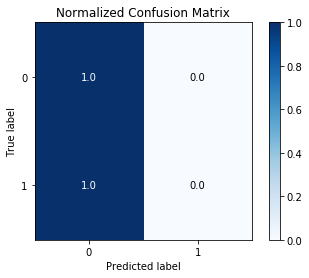

In [30]:
y_pred = clf.predict(X_test)

print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [44]:
#evaluación contra el testeo externo
df_testo_ext = pd.read_csv("../../data/processed/testeo/m1.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_testo_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 56 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
Churn                             50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARIT

In [45]:
X_testo_ext = df_testo_ext.drop("Churn", axis=1)
y_testeo_ext = df_testo_ext["Churn"]

In [46]:
y_pred_testeo_ext = clf.predict(X_testo_ext)
roc_auc_score(y_testeo_ext, y_pred_testeo_ext)

0.6929012625339299

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


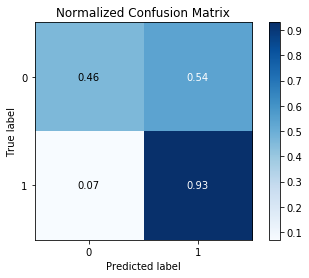

In [47]:
skplt.metrics.plot_confusion_matrix(y_testeo_ext, y_pred_testeo_ext, normalize=True)

# Optimizando parametros

In [12]:
#param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range = [6, 8, 12]
param_range_fl = [1.0, 0.5, 0.1]
class_weight_range = [{0:1, 1:10},{0:1, 1:20},{0:1, 1:25}]
#param_range_fl = np.power(10., np.arange(-4, 4))


#'clf__max_depth': param_range,
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__min_samples_split': param_range,
    'clf__class_weight' : class_weight_range}]

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])

# Construct grid searches
jobs = -1
#scoring = "roc_auc"
#scoring = "roc_auc" #http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
cv = 3

#refit=True, entrena el mejor modelo obtenido con todo el dataset! :D
#verbose => mientras mayor el número, más info va mostrando.
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring=scoring,
            cv=cv,
            verbose=2,
            refit="AUC",
            n_jobs=jobs)
gs_rf

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0...timators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'clf__criterion': ['gini', 'entropy'], 'clf__min_samples_leaf': [6, 8, 12], 'clf__min_samples_split': [6, 8, 12], 'clf__class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 25}]}],
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=2)

In [13]:
# Fit grid search	
gs_rf.fit(X_train, y_train)
# Best params
print('Best params: %s' % gs_rf.best_params_)
# Best training data roc auc
print('Best training roc auc: %.3f' % gs_rf.best_score_)
# Predict on test data with best params
y_pred_gs_rf = gs_rf.predict(X_test)
# Test data roc auc of model with best params
print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred_gs_rf))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  22.3s
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  23.2s
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 

[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.1min


[CV]  clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12, total=  23.5s
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12, total=  25.6s
[CV]  clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  26.8s
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  26.1s
[CV] clf__class_weight={0: 1, 1: 10}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 

[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  26.2s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=12, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12, total=  25.5s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=12, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12, total=  26.4s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=12, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12, total=  25.8s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=

[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  24.2s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  24.8s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  23.5s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12, total=  23.7s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1:

[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  26.4s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  24.7s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  26.2s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  26.3s
[CV] clf__class_weight={0: 1, 1: 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.6min


[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=6, total=  25.2s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=6, total=  26.4s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  25.6s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  24.3s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 22.4min finished


Best params: {'clf__class_weight': {0: 1, 1: 25}, 'clf__criterion': 'gini', 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 6}
Best training roc auc: 0.881
Test set roc auc score for best params: 0.825 


/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


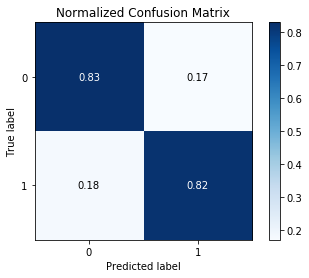

In [14]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_gs_rf, normalize=True)

In [15]:
#evaluación contra el testeo externo
df_testo_ext = pd.read_csv("../../data/processed/testeo/m1.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_testo_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 56 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
Churn                             50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARIT

In [16]:
X_testo_ext = df_testo_ext.drop("Churn", axis=1)
y_testeo_ext = df_testo_ext["Churn"]

In [17]:
X_testo_ext.head()

,6m,5m,4m,3m,2m,1m,edad_r,GENDER_F,GENDER_M,MARITAL_STATUS_Casado,...,CITY_SANTIAGO DEL ESTERO,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM
1690,0,0,0,0,0,0,5,0,1,1,...,0,0,0,0,1,0,0,0,0,0
5575,2,2,2,2,2,1,4,0,1,1,...,0,0,0,0,0,1,0,0,0,0
7968,2,2,2,2,2,2,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
9028,2,2,2,2,2,2,4,0,1,1,...,0,0,0,0,0,1,0,0,0,0
9860,1,1,1,1,1,0,4,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
clf = gs_rf.best_estimator_
clf

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

In [19]:
y_pred_testeo_ext = clf.predict(X_testo_ext)

In [20]:
roc_auc_score(y_testeo_ext, y_pred_testeo_ext)

0.6903824356150207

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


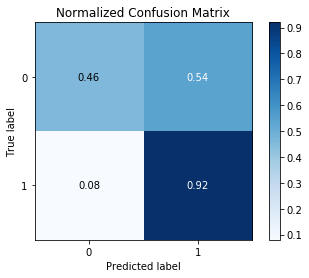

In [21]:
skplt.metrics.plot_confusion_matrix(y_testeo_ext, y_pred_testeo_ext, normalize=True)

In [22]:
gs_rf.best_estimator_

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

In [23]:
#bajando el modelo
from sklearn.externals import joblib

joblib.dump(gs_rf.best_estimator_, '../../models/M1.1 - Modelo RandomForest (0.-0.) - Churn estricto- 6m.N.polizaXmes y Info.Cliente.M.Pago.pkl')

['../../models/M1.1 - Modelo RandomForest (0.-0.) - Churn estricto- 6m.N.polizaXmes y Info.Cliente.M.Pago.pkl']

# Realizando predicción para entregar

In [64]:
df_pred = pd.read_csv("../../data/processed/test_cliente/m1.0 - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 55 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARITAL_STATUS_Union Civ          50000 non-null int64
MARIT

In [65]:
y_pred_predFin  = gs_rf.best_estimator_.predict_proba(df_pred)

In [95]:
csv = pd.DataFrame()
csv["CUSTOMER_ID"] = df_pred.index.values
csv["PRED"] = pd.DataFrame(y_pred_predFin)[1]
csv.set_index("CUSTOMER_ID", inplace=True)
csv.head()

,CUSTOMER_ID,PRED
0,1690,0.006911
1,5575,0.096964
2,7968,0.134929
3,9028,0.035026
4,9860,0.010475


In [96]:
csv.to_csv("../../data/processed/prediccion_para_cliente/m1.0 - predict - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv")